In [2]:
import numpy as np
import struct
from array import array
from os.path import join

class MnistDataLoader(object):
    def __init__(self, training_images_filepath, training_labels_filepath, 
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_image_labels(self, image_filepath, labels_filepath): 
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(image_filepath,'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i+1) * rows * cols])
            img = img.reshape(28,28)
            images[i][:] = img
        return images, labels

    def load_data(self):
        x_train, y_train = self.read_image_labels(training_images_filepath, training_labels_filepath)
        x_test, y_test = self.read_image_labels(test_images_filepath, test_labels_filepath)
        return (x_train, y_train), (x_test, y_test)


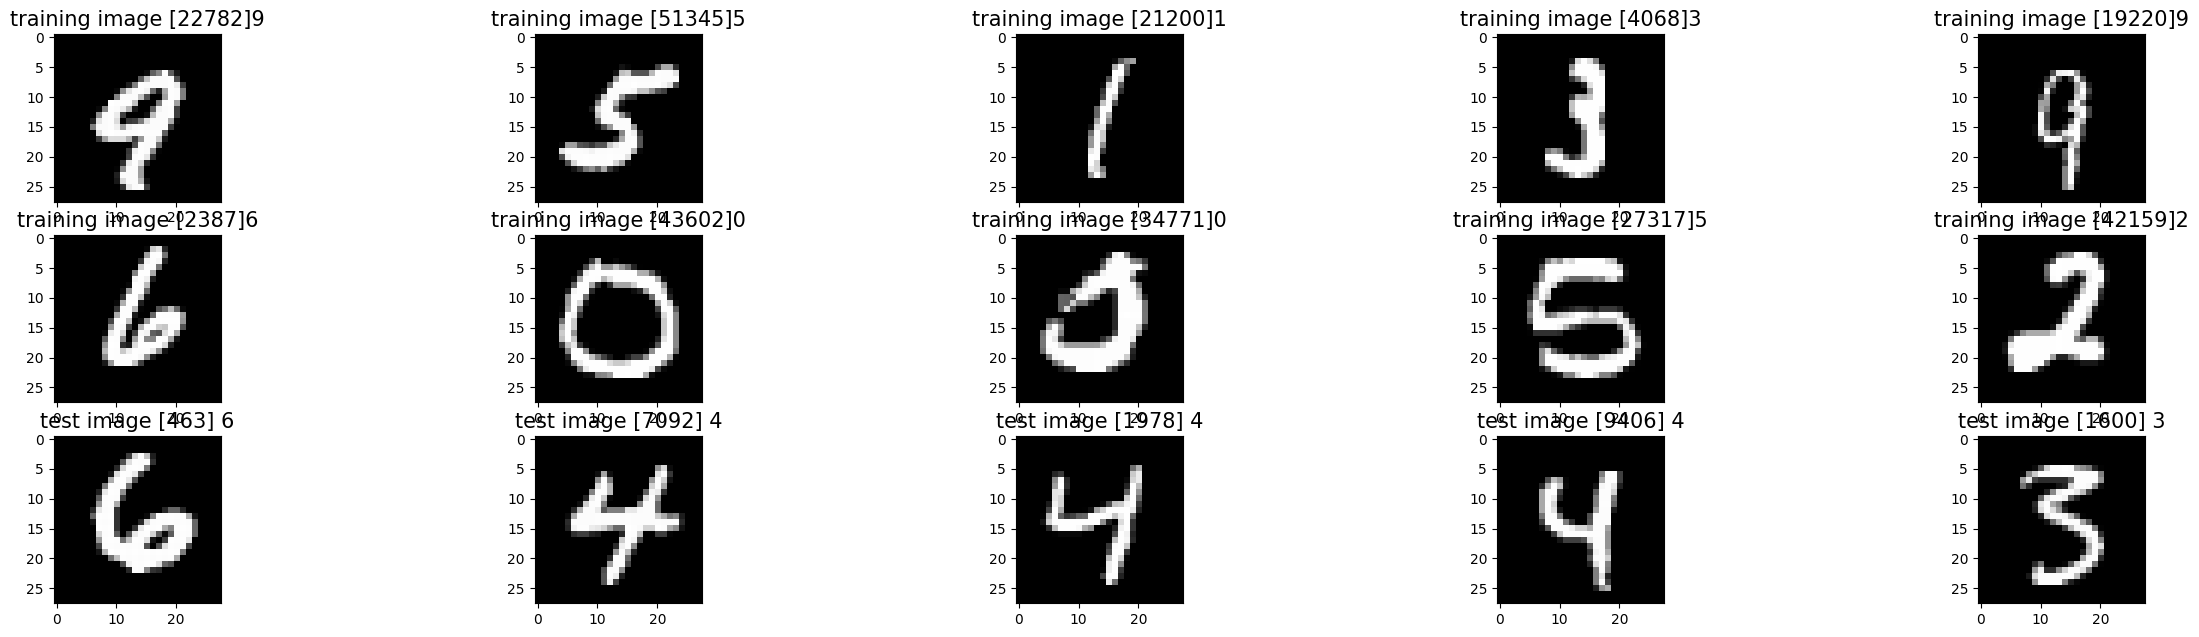

In [3]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

input_path = '../input'
training_images_filepath = join('data', 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join('data', 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join('data', 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join('data', 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols)+1
    plt.figure(figsize=(30,10))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize=15)
        index += 1

mnist_dataloader = MnistDataLoader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

images_to_show = []
titles_to_show = []
for i in range(0, 10):
    r = random.randint(0, 60000)
    images_to_show.append(x_train[r])
    titles_to_show.append('training image [' + str(r) + ']' + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(0, 10000)
    images_to_show.append(x_test[r])
    titles_to_show.append('test image [' + str(r) + '] ' + str(y_test[r]))

show_images(images_to_show, titles_to_show)

In [4]:
def ReLU(Z):
    return np.maximum(0, Z)

def deriv_ReLU(Z):
    return Z > 0

def softmax(Z):
    Z_shift = Z - np.max(Z, axis=0, keepdims=True)
    exp_Z = np.exp(Z_shift)
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def readify_data(x):
    x = np.array(x)
    x = x.reshape(x.shape[0], -1)
    return x.T

def one_hot(y):
    len_y = len(y)
    one_hot_y = np.zeros((len_y, 10))
    one_hot_y[np.arange(len_y), y] = 1
    one_hot_y = one_hot_y.T
    return one_hot_y

def init_params():
    w1 = np.random.randn(10, 784) - 0.5
    b1 = np.random.randn(10, 1) - 0.5
    w2 = np.random.randn(10, 10) - 0.5
    b2 = np.random.randn(10, 1) - 0.5
    return w1, b1, w2, b2

def feed_forward(x, w1, b1, w2, b2):
    z1 = w1.dot(x) + b1
    a1 = ReLU(z1)
    z2 = w2.dot(a1) + b2
    a2 = softmax(z2)
    return z1, a1, z2, a2

def back_prop(z1, a1, z2, a2, w2, x, one_hot_y):
    m = one_hot_y.shape[1]
    dz2 = a2 - one_hot_y
    dw2 = 1 / m * dz2.dot(a1.T)
    db2 = 1 / m * np.sum(dz2, axis=1, keepdims=True)
    dz1 = w2.T.dot(dz2) * deriv_ReLU(z1)
    dw1 = 1 / m * dz1.dot(x.T)
    db1 = 1 / m * np.sum(dz1, axis=1, keepdims=True)
    loss = 1/m * -np.sum(one_hot_y * np.log(a2 + 1e-8))
    return dw2, db2, dw1, db1, loss

def update_params(w1, b1, w2, b2, dw1, db1, dw2, db2, LR):
    w1 = w1 - LR * dw1
    b1 = b1 - LR * db1
    w2 = w2 - LR * dw2
    b2 = b2 - LR * db2
    return w1, b1, w2, b2




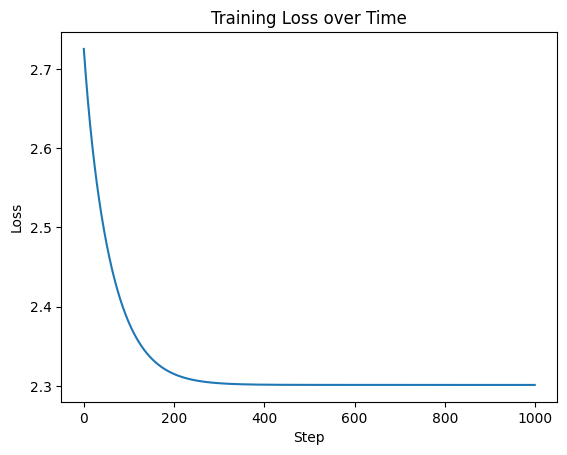

In [6]:
# Next: Figure out how to use matplotlib to graph the average loss using a cost function and run a training process
# For the graph: Find the average loss of each case and determine the average
import matplotlib.pyplot as plt

x = readify_data(x_train)
one_hot_y = one_hot(y_train)
num_steps = 1000
LR = .1

x_data = []
y_data = []


w1, b1, w2, b2 = init_params()
for i in range(num_steps):
    z1, a1, z2, a2 = feed_forward(x, w1, b1, w2, b2)
    dw2, db2, dw1, db1, loss = back_prop(z1, a1, z2, a2, w2, x, one_hot_y)
    w1, b1, w2, b2 = update_params(w1, b1, w2, b2, dw1, db1, dw2, db2, LR)

    x_data.append(i)
    y_data.append(loss)


    
plt.figure()
plt.plot(x_data, y_data)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss over Time")
plt.show()


In [7]:
def test_model(x, w1, b1, w2, b2):
    z1 = w1.dot(x) + b1
    a1 = ReLU(z1)
    z2 = w2.dot(a1) + b2
    a2 = softmax(z2)
    return a2